In [ ]:
pip install yfinance numpy pandas scikit-learn tensorflow

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Unduh data BBCA
ticker = 'BBCA.JK'  # Simbol saham BBCA di Yahoo Finance
data = yf.download(ticker, start='2010-01-01', end='2024-08-13')

# Gunakan harga penutupan
data = data[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Buat dataset dengan window size 60
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data menjadi training dan testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0150 - val_loss: 6.0181e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.5285e-04 - val_loss: 5.8092e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5727e-04 - val_loss: 5.1831e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3927e-04 - val_loss: 5.0796e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.6069e-04 - val_loss: 4.6947e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4652e-04 - val_loss: 5.4777e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3893e-04 - val_loss: 5.0590e-04
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3797e-04 - val_loss: 4.1696e-04
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0947e-04 - val_loss: 3.9363e-04
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2476e-04 - val_loss: 6.1053e-04
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3854e-04 - val_loss: 3.

In [ ]:
# Prediksi
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_inv = scaler.inverse_transform([y_test])

# Hitung MSE
mse = mean_squared_error(y_test_inv[0], predicted_prices)
print(f'Mean Squared Error: {mse}')

# Ambil data terakhir dari dataset yang digunakan untuk pelatihan
last_data = scaled_data[-time_step:]

# Buat array untuk menyimpan prediksi
future_predictions = []
num_future_steps = 4 * 21  # 4 bulan (asumsi 21 trading days per bulan)
current_step = last_data.reshape(1, time_step, 1)

for _ in range(num_future_steps):
    predicted_price = model.predict(current_step)
    future_predictions.append(predicted_price[0, 0])
    # Update current_step dengan menggeser data dan menambahkan prediksi terbaru
    current_step = np.concatenate((current_step[:, 1:, :], predicted_price.reshape(1, 1, 1)), axis=1)

# Transformasikan hasil prediksi kembali ke skala asli
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Squared Error: 24417.301870673607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

             Start Price    End Price  Average Price
Date                                                
2024-08-31  10029.960938  8143.628906    8963.516602
2024-09-30   8065.516113  7206.271484    7534.575684
2024-10-31   7188.437500  6977.693359    7063.309570
2024-11-30   6972.520508  6900.833984    6932.707031
2024-12-31   6898.372559  6891.436523    6894.868164


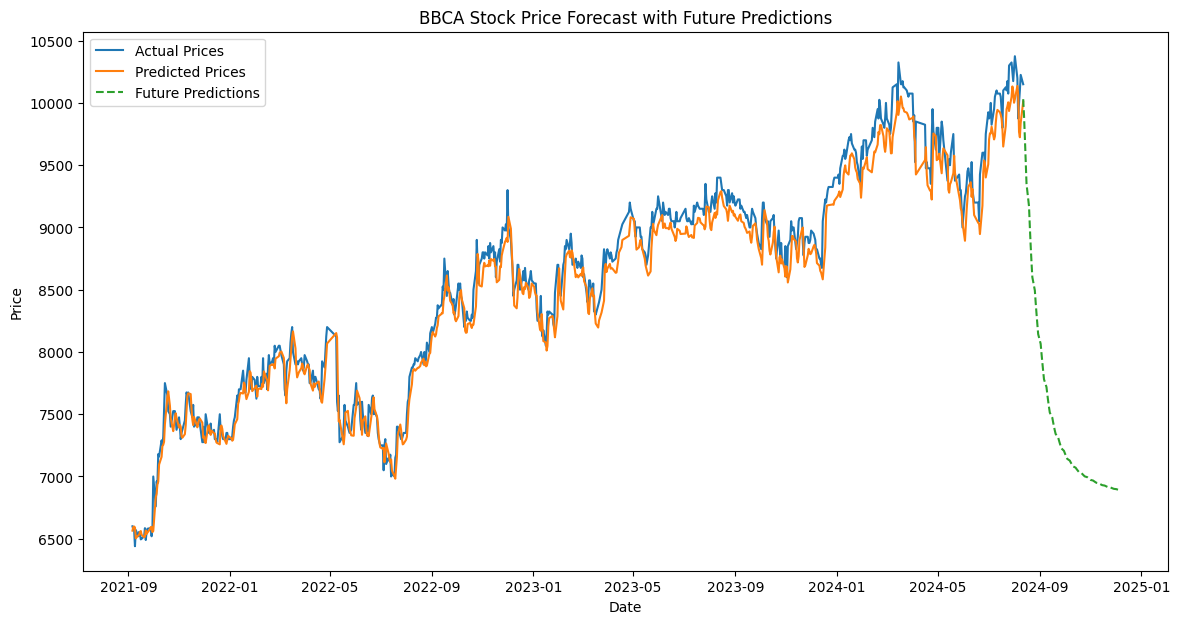

In [ ]:
# Buat tanggal untuk prediksi masa depan
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=num_future_steps, freq='B')  # 'B' untuk hari kerja

# Buat DataFrame untuk prediksi
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted Price': future_predictions.flatten()})

# Rangkuman bulanan
monthly_summary = future_df.set_index('Date').resample('M').agg({
    'Predicted Price': ['first', 'last', 'mean']
})
monthly_summary.columns = ['Start Price', 'End Price', 'Average Price']

# Tampilkan ringkasan bulanan
print(monthly_summary)

# Plot hasil
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_inv[0], label='Actual Prices')
plt.plot(data.index[-len(predicted_prices):], predicted_prices, label='Predicted Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BBCA Stock Price Forecast with Future Predictions')
plt.legend()
plt.show()

In [ ]:
# Simpan model ke file .h5
model.save('lstm_stock_model.h5')
print("Model saved to lstm_stock_model.h5")


Model saved to lstm_stock_model.h5
